In [5]:
import os
os.listdir("../data")


['Online Retail.xlsx']

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel("../data/raw/Online Retail.xlsx")
df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [11]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [19]:
df = df.dropna(subset=["CustomerID"])

In [21]:
df = df.drop_duplicates()


In [23]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]



In [25]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [27]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [29]:
df.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,392692.000000,392692,392692.000000,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865,22.631500
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,4.950000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,12.450000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,180.492832,NaN,22.241836,1713.539549,311.099224


In [31]:
df[["Quantity", "UnitPrice", "TotalPrice"]].describe()


,Quantity,UnitPrice,TotalPrice
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [35]:
import matplotlib.pyplot as plt


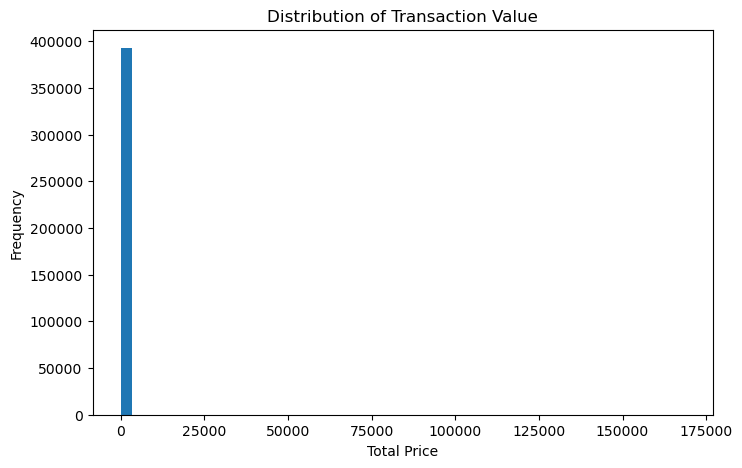

In [37]:
plt.figure(figsize=(8,5))
plt.hist(df["TotalPrice"], bins=50)
plt.title("Distribution of Transaction Value")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()


In [41]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

In [43]:
rfm = (
    df.groupby("CustomerID")
    .agg({
        "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
        "InvoiceNo": "nunique",
        "TotalPrice": "sum"
    })
)

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [45]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


In [51]:
rfm.groupby("Cluster").mean()


,Recency,Frequency,Monetary
Cluster,,,
0,40.983906,4.852677,2005.830431
1,246.023788,1.582800,629.357439
2,7.142857,80.214286,122748.792143


In [ ]:
### Customer Segments Interpretation

- **Cluster 0**: High-value customers (frequent and high spenders)
- **Cluster 1**: Medium-value customers
- **Cluster 2**: Low-value or inactive customers

Business actions:
- Reward Cluster 0 with loyalty programs
- Upsell Cluster 1
- Re-engage Cluster 2 with promotions


In [53]:
rfm["CLV"] = rfm["Monetary"] * rfm["Frequency"]
rfm.head()


,Recency,Frequency,Monetary,Cluster,CLV
CustomerID,,,,,
12346.0,326,1,77183.60,1,77183.60
12347.0,2,7,4310.00,0,30170.00
12348.0,75,4,1797.24,0,7188.96
12349.0,19,1,1757.55,0,1757.55
12350.0,310,1,334.40,1,334.40


In [55]:
rfm.sort_values("CLV", ascending=False).head(10)


,Recency,Frequency,Monetary,Cluster,CLV
CustomerID,,,,,
14911.0,1,201,143711.17,2,28885945.17
14646.0,2,73,280206.02,2,20455039.46
18102.0,1,60,259657.30,2,15579438.00
17450.0,8,46,194390.79,2,8941976.34
12748.0,1,209,33053.19,2,6908116.71
14156.0,10,55,117210.08,2,6446554.40
13089.0,3,97,58762.08,2,5699921.76
15311.0,1,91,60632.75,2,5517580.25
16029.0,39,63,80850.84,2,5093602.92


In [57]:
rfm.groupby("Cluster")["CLV"].mean()


Cluster
0    2.616358e+04
1    1.526525e+03
2    8.399121e+06
Name: CLV, dtype: float64

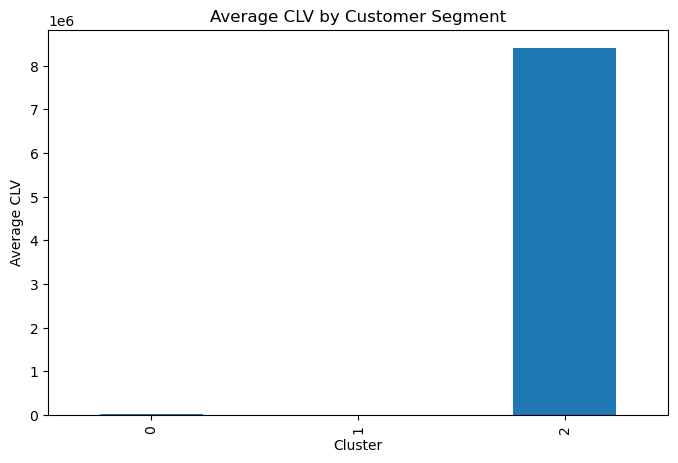

In [59]:
rfm.groupby("Cluster")["CLV"].mean().plot(
    kind="bar",
    title="Average CLV by Customer Segment",
    figsize=(8,5)
)
plt.ylabel("Average CLV")
plt.show()


In [ ]:
## Key Business Insights

- A small group of customers contributes the majority of revenue.
- High-value customers purchase frequently and have high monetary value.
- Sales show strong seasonality with peaks during certain months.
- Certain products dominate sales volume and should be prioritized.
- Customer segmentation reveals opportunities for targeted marketing.

### Recommendations
- Focus retention efforts on high-value customers.
- Use personalized offers to upgrade mid-tier customers.
- Re-engage low-value customers with discounts or reminders.


In [3]:
df.shape


(541909, 8)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.describe()



,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [12]:
df.isna().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [14]:
df = df.dropna(subset=["CustomerID"])
df.shape


(406829, 8)

In [16]:
# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Remove negative or zero quantities
df = df[df["Quantity"] > 0]

# Remove zero or negative prices
df = df[df["UnitPrice"] > 0]

df.shape


(397884, 8)

In [18]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create total price column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# Create processed data folder if not exists
import os
os.makedirs("../data/processed", exist_ok=True)

# Save cleaned data
df.to_csv("../data/processed/online_retail_cleaned.csv", index=False)


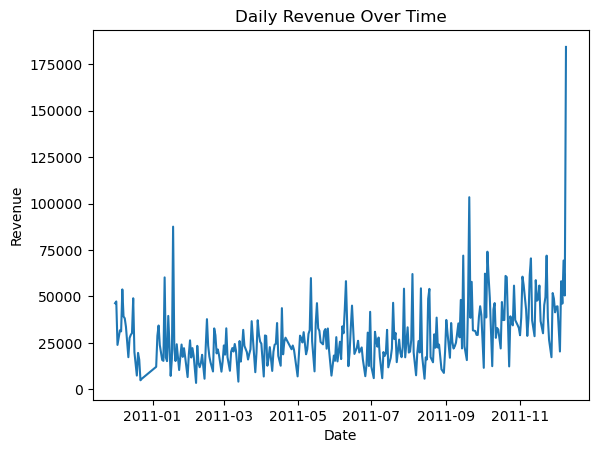

In [22]:
import matplotlib.pyplot as plt

# Create date column
df["Date"] = df["InvoiceDate"].dt.date

daily_revenue = df.groupby("Date")["TotalPrice"].sum()

plt.figure()
plt.plot(daily_revenue)
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


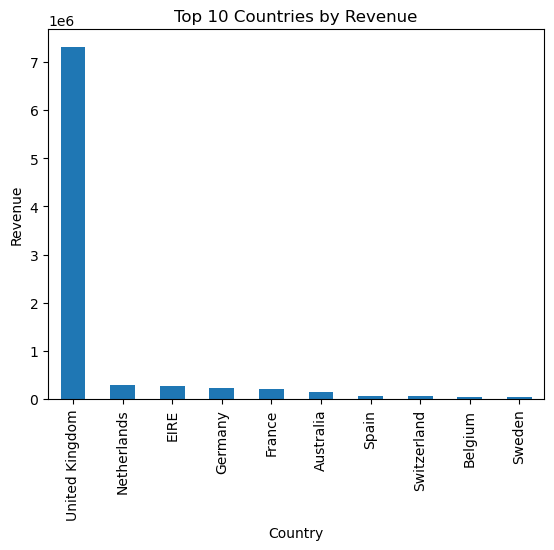

In [24]:
country_revenue = (
    df.groupby("Country")["TotalPrice"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure()
country_revenue.plot(kind="bar")
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.show()


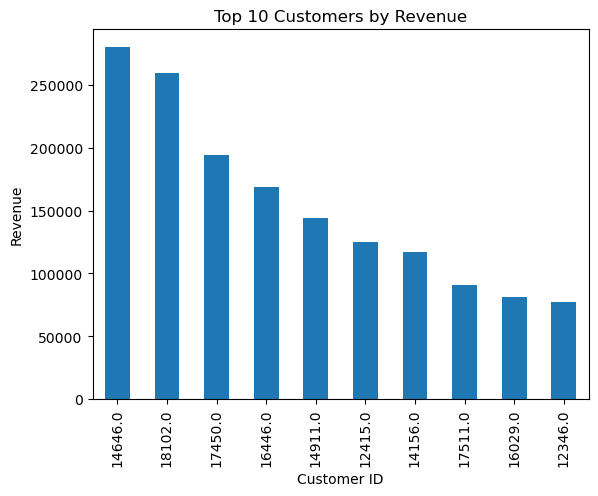

In [26]:
top_customers = (
    df.groupby("CustomerID")["TotalPrice"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure()
top_customers.plot(kind="bar")
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.show()


In [28]:
# Set snapshot date (one day after last invoice)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "count",                                     # Frequency
    "TotalPrice": "sum"                                       # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [30]:
# Create RFM scores
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

# Combine scores
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,310,17,334.40,1,1,2,112


In [32]:
def segment_customer(row):
    if row["R_Score"] == "4" and row["F_Score"] == "4" and row["M_Score"] == "4":
        return "Champions"
    elif row["R_Score"] in ["3", "4"] and row["F_Score"] in ["3", "4"]:
        return "Loyal Customers"
    elif row["R_Score"] == "4" and row["F_Score"] == "1":
        return "New Customers"
    elif row["R_Score"] == "1" and row["F_Score"] in ["3", "4"]:
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

rfm["Segment"].value_counts()


Segment
Others    4338
Name: count, dtype: int64

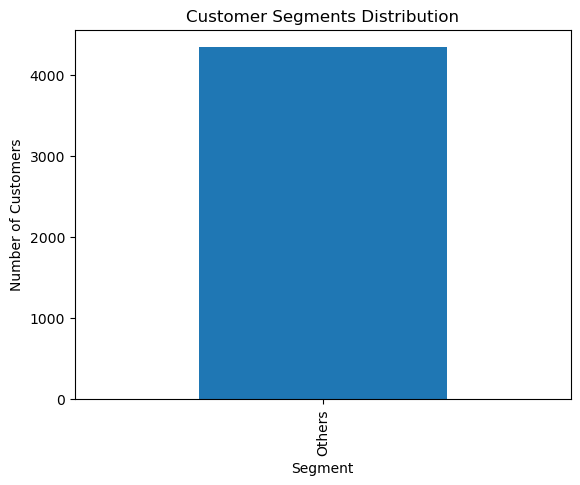

In [34]:
segment_counts = rfm["Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer Segments Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


In [36]:
rfm.to_csv("../data/processed/rfm_segments.csv")


In [ ]:
### Key Insights
- A small percentage of customers (Champions) contribute a large share of revenue.
- Loyal customers show high purchase frequency and should be targeted with retention campaigns.
- At-risk customers have not purchased recently and may churn without re-engagement.
